# Simulate new trajectories from a kriging metamodel

The main goal of this example is to show how to simulate new trajectories from a kriging metamodel.

## Introduction

We consider the sine function:

$$
y = \sin(x)
$$

for any $x\in[0,12]$. 

We want to create a metamodel of this function. This is why we create a sample of $n$ observations of the function:

$$
y_i=\sin(x_i)
$$

for $i=1,...,7$, where $x_i$ is the i-th input and $y_i$ is the corresponding output. 

We consider the seven following inputs :

| $i$ | 1 | 2 | 3 | 4 | 5 | 6 | 7 |
|---|---|---|---|---|---|---|---|
| $x_i$ | 1 | 3 | 4 | 6 | 7.9 | 11 | 11.5 |

We are going to consider a kriging metamodel with a 

* constant trend,
* a Matern covariance model. 

## Creation of the metamodel

We begin by defining the function `g` as a symbolic function. Then we define the `x_train` variable which contains the inputs of the design of experiments of the training step. Then we compute the `y_train` corresponding outputs. The variable `n_train` is the size of the training design of experiments.

In [1]:
import numpy as np
import openturns as ot

In [2]:
g = ot.SymbolicFunction(['x'], ['sin(x)'])

In [3]:
x_train = ot.Sample([1.,3.,4.,6.,7.9,11., 11.5],1)
y_train = g(x_train)
n_train = x_train.getSize()
n_train

7

In order to compare the function and its metamodel, we use a test (i.e. validation) design of experiments made of a regular grid of 100 points from 0 to 12. Then we convert this grid into a `Sample` and we compute the outputs of the function on this sample.  

In [4]:
xmin = 0.
xmax = 12.
n_test = 100
step = (xmax-xmin)/(n_test-1)
myRegularGrid = ot.RegularGrid(xmin, step, n_test)
x_test_coord = myRegularGrid.getValues()
x_test = ot.Sample(x_test_coord,1)
y_test = g(x_test)

In order to observe the function and the location of the points in the input design of experiments, we define the following functions which plots the data.

In [5]:
def plot_data_train(x_train,y_train):
    '''Plot the data (x_train,y_train) as a Cloud, in red'''
    graph_train = ot.Cloud(x_train,y_train)
    graph_train.setColor("red")
    graph_train.setLegend("Data")
    return graph_train

In [6]:
def plot_data_test(x_test,y_test):
    '''Plot the data (x_test,y_test) as a Curve, in dashed black'''
    graphF = ot.Curve(x_test,y_test)
    graphF.setLegend("Exact")
    graphF.setColor("black")
    graphF.setLineStyle("dashed")
    return graphF

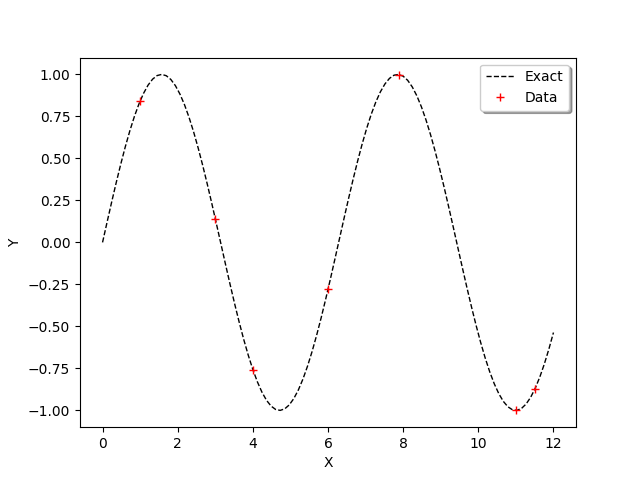

In [7]:
graph = ot.Graph()
graph.add(plot_data_test(x_test,y_test))
graph.add(plot_data_train(x_train,y_train))
graph.setAxes(True)
graph.setXTitle("X")
graph.setYTitle("Y")
graph.setLegendPosition("topright")
graph

We use the `ConstantBasisFactory` class to define the trend and the `MaternModel` class to define the covariance model. This Matérn model is based on the regularity parameter $\nu=3/2$.

In [8]:
dimension = 1
basis = ot.ConstantBasisFactory(dimension).build()
covarianceModel = ot.MaternModel([1.]*dimension, 1.5)
algo = ot.KrigingAlgorithm(x_train, y_train, covarianceModel, basis)
algo.run()
krigingResult = algo.getResult()
krigingResult

class=KrigingResult, basis=[class=Basis coll=[class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,y0] evaluationImplementation=class=LinearEvaluation name=Unnamed center=class=Point name=Unnamed dimension=1 values=[0] constant=class=Point name=Unnamed dimension=1 values=[1] linear=class=Matrix implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[0] gradientImplementation=class=ConstantGradient name=Unnamed constant=class=Matrix implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[0] hessianImplementation=class=NullHessian name=Unnamed inputDimension=1 outputDimension=1]], trend coefficients=[class=Point name=Unnamed dimension=1 values=[0.00736738]], covariance models=class=MaternModel scale=class=Point name=Unnamed dimension=1 values=[0.318568] amplitude=class=Point name=Unnamed dimension=1 values=[0.822262] nu=1.5, covariance coefficients=class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=7 dimension=1 data=[[1.13905],[1.01761],[-1.76279],[-0.559147],[1.78757],[-1.61945],[-0.00284256]]

We observe that the `scale` and `amplitude` hyper-parameters have been optimized by the `run` method. Then we get the metamodel with `getMetaModel` and evaluate the outputs of the metamodel on the test design of experiments.

In [9]:
krigeageMM = krigingResult.getMetaModel()
y_test_MM = krigeageMM(x_test)

The following function plots the kriging data.

In [10]:
def plot_data_kriging(x_test,y_test_MM):
    '''Plots (x_test,y_test_MM) from the metamodel as a Curve, in blue'''
    graphK = ot.Curve(x_test,y_test_MM)
    graphK.setColor("blue")
    graphK.setLegend("Kriging")
    return graphK

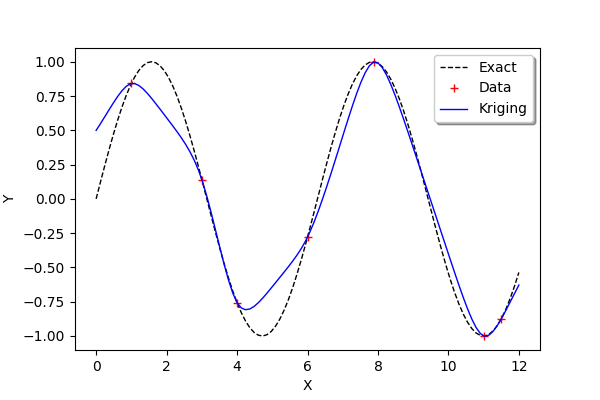

In [11]:
graph = ot.Graph()
graph.add(plot_data_test(x_test,y_test))
graph.add(plot_data_train(x_train,y_train))
graph.add(plot_data_kriging(x_test,y_test_MM))
graph.setAxes(True)
graph.setXTitle("X")
graph.setYTitle("Y")
graph.setLegendPosition("topright")
graph

## Simulate new trajectories

In order to generate new trajectories of the conditioned gaussian process, we couild technically use the `KrigingRandomVector` class, because it provides the `getSample` method that we need. However, the `KrigingRandomVector` class was more specifically designed to create a `RandomVector` so that it can feed, for example, a function which has a field as input argument. 

This is why we use the `ConditionedGaussianProcess`, which provides a `Process`. 

In [12]:
n_test = 100
step = (xmax-xmin)/(n_test-1)
myRegularGrid = ot.RegularGrid(xmin, step, n_test)
vertices = myRegularGrid.getVertices()

If we directly use the `vertices` values, we get:

    RuntimeError: InternalException : Error: the matrix is not definite positive.
    
Indeed, some points in `vertices` are also in `x_train`. This is why the conditioned covariance matrix is singular at these points. 

This is why we define the following function which deletes points in `vertices` which are also found in `x_train`.

In [13]:
def deleteCommonValues(x_train,x_test):
    '''
    Delete from x_test the values which are in x_train so that 
    values in x_test have no interect with x_train.
    '''
    x_test_filtered = x_test # Initialize
    for x_train_value in x_train:
        print("Checking %s" % (x_train_value))
        indices = np.argwhere(x_test==x_train_value)
        if len(indices) == 1:
            print("   Delete %s" % (x_train_value))
            x_test_filtered = np.delete(x_test_filtered, indices[0, 0])
        else:
            print("   OK")
    return x_test_filtered

In [14]:
vertices_filtered = deleteCommonValues(np.array(x_train.asPoint()),np.array(vertices.asPoint()))

Checking 1.0
   OK
Checking 3.0
   OK
Checking 4.0
   Delete 4.0
Checking 6.0
   OK
Checking 7.9
   OK
Checking 11.0
   OK
Checking 11.5
   OK


In [15]:
evaluationMesh = ot.Mesh(ot.Sample(vertices_filtered,1))

In [16]:
process = ot.ConditionedGaussianProcess(krigingResult, evaluationMesh)

In [17]:
trajectories = process.getSample(10)
type(trajectories)

openturns.func.ProcessSample

The `getSample` method returns a `ProcessSample`. By comparison, the `getSample` method of a `KrigingRandomVector` would return a `Sample`. 

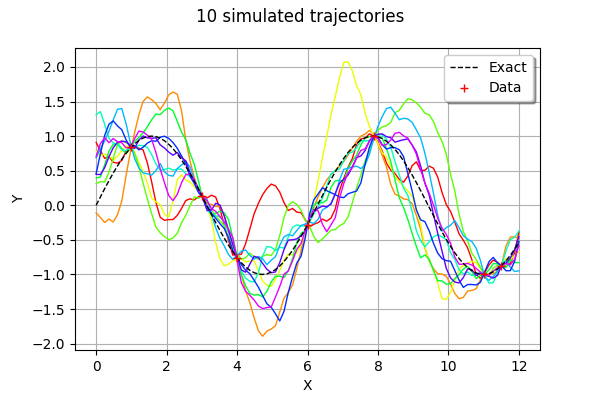

In [18]:
graph = trajectories.drawMarginal()
graph.add(plot_data_test(x_test,y_test))
graph.add(plot_data_train(x_train,y_train))
graph.setAxes(True)
graph.setXTitle("X")
graph.setYTitle("Y")
graph.setLegendPosition("topright")
graph.setTitle("10 simulated trajectories")
graph

## References

* Metamodeling with Gaussian processes, Bertrand Iooss, EDF R&D, 2014, www.gdr-mascotnum.fr/media/sssamo14_iooss.pdf
